In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import random
import os
import shutil 
import time
import copy

from tqdm import tqdm   # Progress bar iterator

import torch
import torchvision
from torchvision import transforms, models

random.seed(666)
np.random.seed(666)
torch.manual_seed(666)
torch.cuda.manual_seed(666)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Any results you write to the current directory are saved as output.
print(os.listdir("../input"))

['plates']


In [2]:
data_root = '../input/plates/plates'
print(os.listdir(data_root))

['test', 'train']


In [3]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

# Создали дерево каталогов (train/clean, train/dirty, val/clean, val/dirty)
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

# Копируем картинки по нужным папкам (каждая шестая в validation)
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(sorted(os.listdir(source_dir)))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 771.59it/s]


In [4]:
# !dir train

In [5]:
# Трансформации - приведение картинок к общему виду
# Normalize - Нужно отнять 3 константы от RGB и поделить на 3 другие константы
# См. мануал по ResNet на сайте PyTorch, там объяснено

train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=180),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.25),
    transforms.RandomResizedCrop(224, scale=(0.4, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.3, hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Генерируем датасеты. Лейблы берутся из названия папки файла, а сами картинки приводятся к общему виду
# train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms) 

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
for i in range(64-1):
    temp_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
    train_dataset = torch.utils.data.ConcatDataset([train_dataset, temp_dataset])

# То же самое для Validation
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)


# Создаём объекты - генераторы пакетов (батчей). num_workers - кол-во одновременных тредов
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)   # num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)  # num_workers=batch_size)

In [6]:
len(train_dataloader), len(train_dataset)
# N батчей из K картинок (K = N * batch_size)

(64, 2048)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


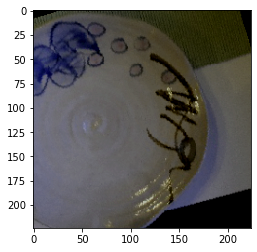

In [7]:
# Посмотрим на любой пример
# permute меняет местами измерения тензора

X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

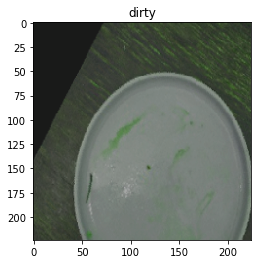

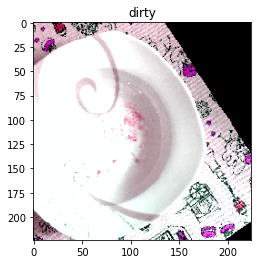

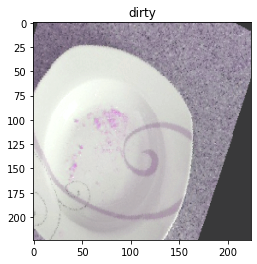

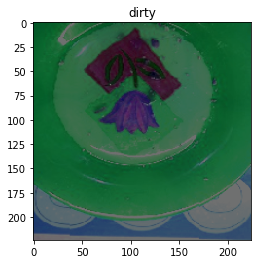

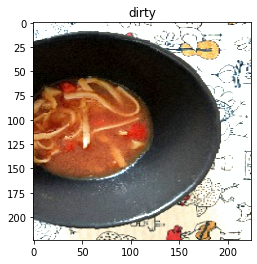

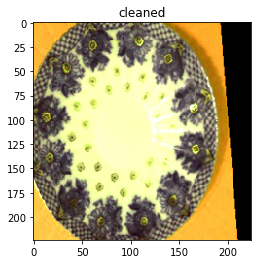

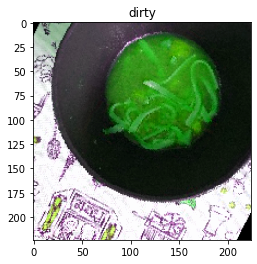

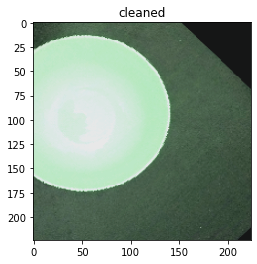

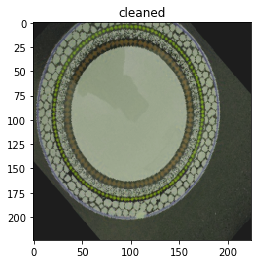

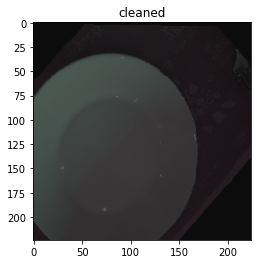

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

i = 10
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])
    i -= 1
    if i == 0:
        break

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    train_batch_loss_history = []
    train_batch_accuracy_history = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}: ', end='')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader: # tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                train_batch_loss = loss_value.item()
                train_batch_accuracy = (preds_class == labels.data).float().mean()
                
                running_loss += train_batch_loss
                running_acc += train_batch_accuracy
                
                train_batch_loss_history.append(train_batch_loss)
                train_batch_accuracy_history.append(train_batch_accuracy)
                
                print(f'----- {phase}, accuracy {train_batch_accuracy * 100:.2f} %, loss {train_batch_loss:.4f}')        


            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)
                # scheduler.step()  - перенёс внутрь батча
            else:
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)               
                print(f'{phase}, accuracy {epoch_acc * 100:.2f} %, loss {epoch_loss:.4f}')        

    plt.figure(figsize=(20,10))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_batch_loss_history, label='Train Batch Loss')
    plt.plot(train_batch_accuracy_history, label='Train Batch Accuracy')
    plt.legend();

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracy_history, label='Train accuracy')
    plt.plot(val_accuracy_history, label='Val accuracy')
    plt.legend();
    
    plt.subplot(1, 3, 3)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.legend();
    
    return model

In [10]:
# ResNet 18 - самый маленький (обычно берут 50)
model = models.resnet50(pretrained=True)

# Disable grad for all conv layers - замораживаем слои ResNet
for param in model.parameters():
    param.requires_grad = False

# Заменяем последний слой на наш (512 входов, 2 выхода) (пересоздаём, поэтому будет разморожен)
model.fc = torch.nn.Linear(model.fc.in_features, 2)

# Кладём на GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Бинарная кросс-энтропия
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1, amsgrad=True)

# Decay LR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

Epoch 0/1: ----- train, accuracy 46.88 %, loss 0.7991
----- train, accuracy 46.88 %, loss 0.8860
----- train, accuracy 50.00 %, loss 0.7173
----- train, accuracy 53.12 %, loss 0.7082
----- train, accuracy 56.25 %, loss 0.6497
----- train, accuracy 46.88 %, loss 0.7295
----- train, accuracy 62.50 %, loss 0.5919
----- train, accuracy 62.50 %, loss 0.6094
----- train, accuracy 56.25 %, loss 0.6614
----- train, accuracy 34.38 %, loss 0.8725
----- train, accuracy 87.50 %, loss 0.4877
----- train, accuracy 81.25 %, loss 0.5366
----- train, accuracy 78.12 %, loss 0.5411
----- train, accuracy 71.88 %, loss 0.5611
----- train, accuracy 78.12 %, loss 0.5286
----- train, accuracy 75.00 %, loss 0.4972
----- train, accuracy 87.50 %, loss 0.4443
----- train, accuracy 93.75 %, loss 0.4278
----- train, accuracy 90.62 %, loss 0.4062
----- train, accuracy 65.62 %, loss 0.5777
----- train, accuracy 78.12 %, loss 0.5191
----- train, accuracy 96.88 %, loss 0.4232
----- train, accuracy 78.12 %, loss 0.5281


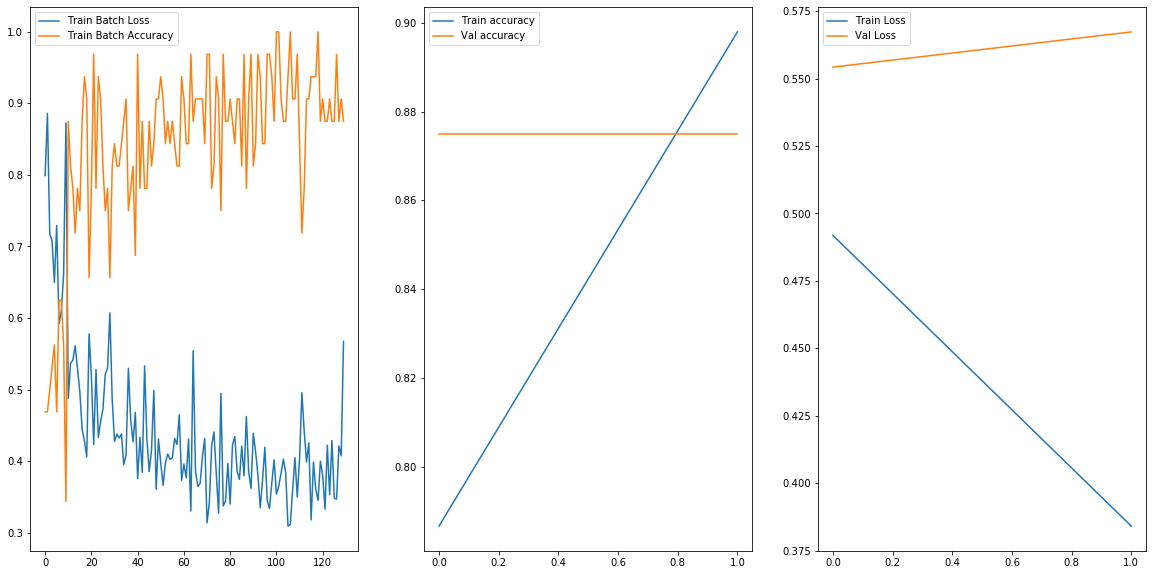

In [11]:
train_model(model, loss, optimizer, scheduler, num_epochs=2);

In [12]:
# Создадим новую папку и скопируем туда тестовый датасет

test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'));

In [13]:
# Расширим класс ImageFolder, чтобы он отдавал не только саму картинку, но и имя файла 
# Не работает под Windows

# class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
#     def __getitem__(self, index):
#         original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
#         path = self.imgs[index][0]
#         tuple_with_path = (original_tuple + (path,))
#         return tuple_with_path
    
# test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

# test_dataloader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [14]:
# Загружаем тестовый датасет из папки test_dir, применяем трансформации
test_dataset = torchvision.datasets.ImageFolder(test_dir, val_transforms)

# Конвертируем в итератор с батчем 8
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [15]:
print(test_dir)
print(len(test_dataloader))

test
24


In [16]:
# # Получаем список файлов из каталога test/unknown. 
# # os.walk возвращает кортеж (каталог, имена подкаталогов, список файлов). Нам нужен список файлов [2]
# test_files = next(iter(os.walk(os.path.join(test_dir, 'unknown'))))[2]

# # Переделываем в спиок меток (отбрасываем '.jpg')
# for i, file in enumerate(test_files):
#     test_files[i] = test_files[i].split('.')[0]

# print(test_files[:10])

In [17]:
# Посмотрим на картинки
X_batch, y_batch = next(iter(test_dataloader))

# for x_item, y_item in zip(X_batch, y_batch):
#     show_input(x_item, title='unknown')

In [18]:
model.eval()

test_predictions = []
#test_img_paths = []
i = 1

for inputs, labels in test_dataloader:
    # paths
    inputs = inputs.cuda()
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    print(f'\r{i}/{len(test_dataloader)}', end='')
    i+=1
    #test_img_paths.extend(next(test_files_iter))
    
test_predictions = np.concatenate(test_predictions)

24/24

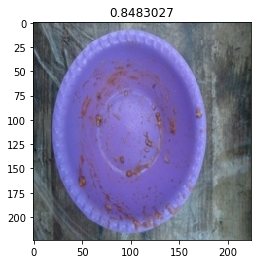

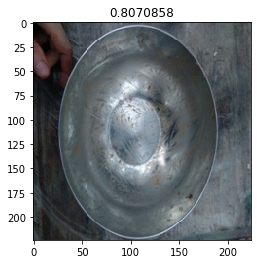

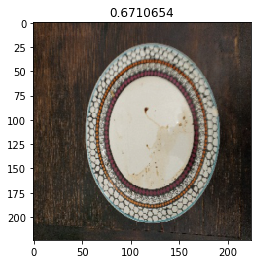

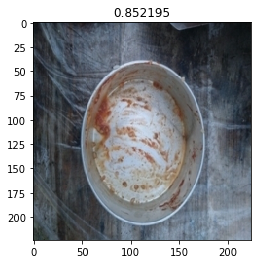

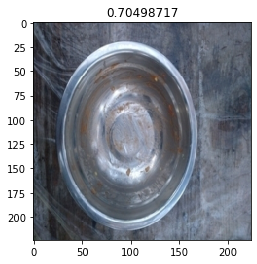

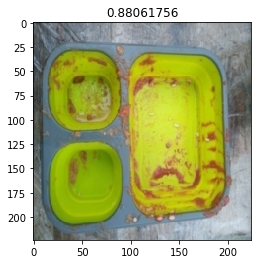

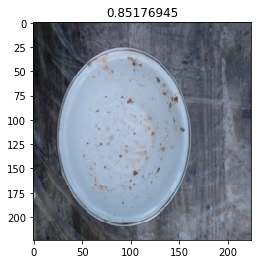

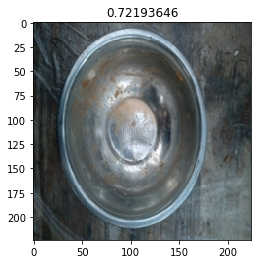

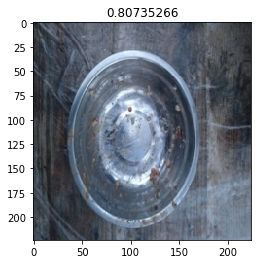

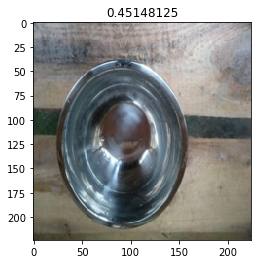

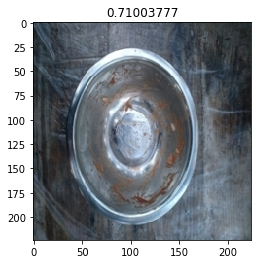

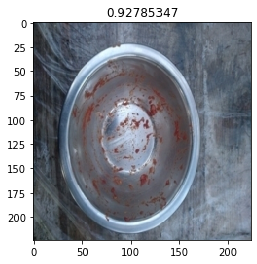

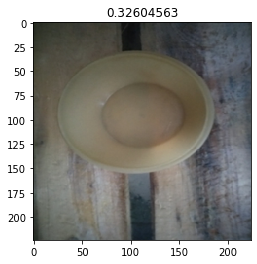

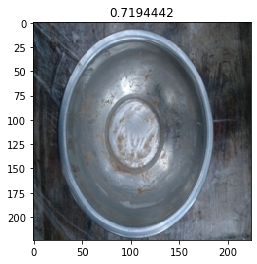

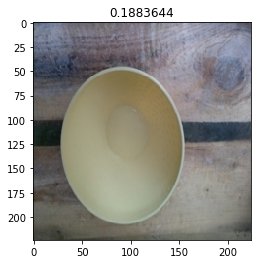

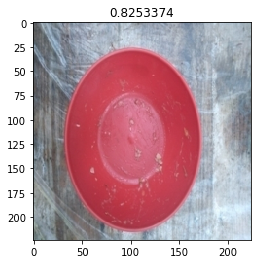

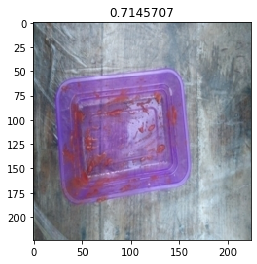

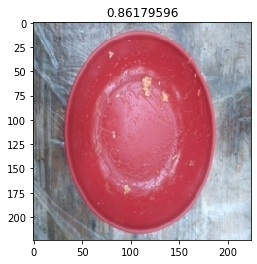

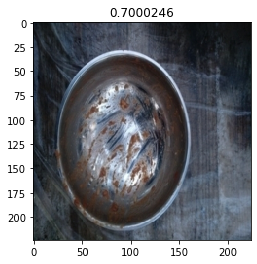

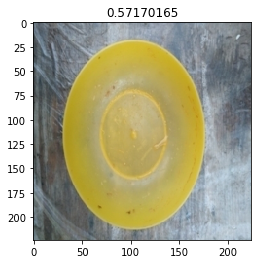

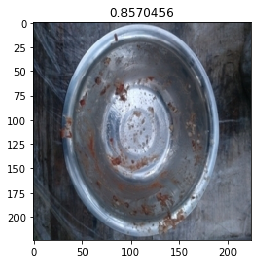

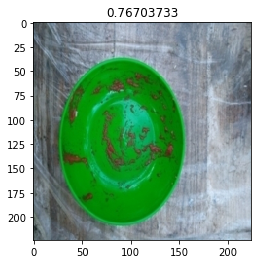

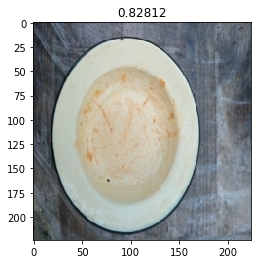

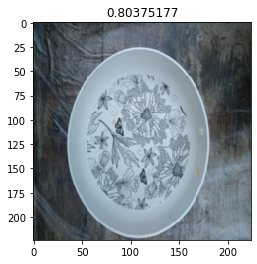

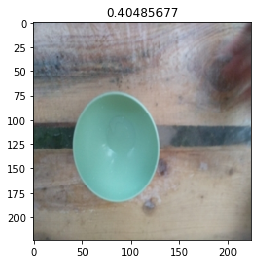

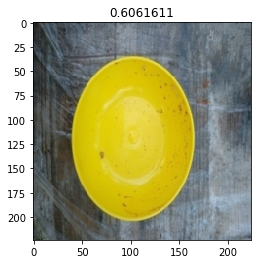

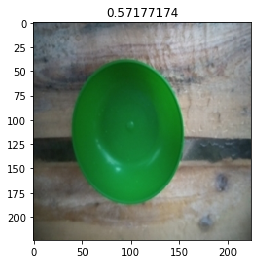

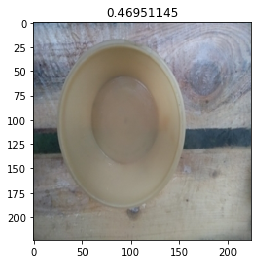

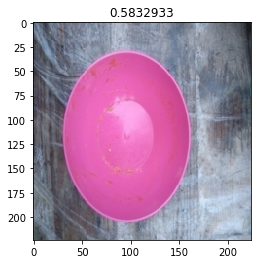

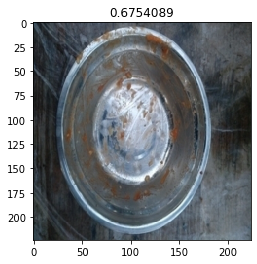

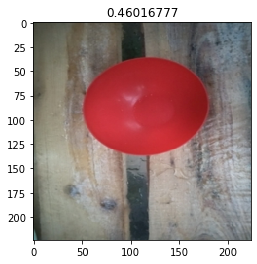

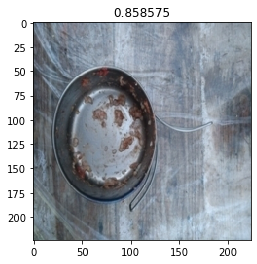

In [19]:
inputs, labels = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [20]:
# Получаем список файлов из каталога test/unknown. 
# os.walk возвращает кортеж (каталог, имена подкаталогов, список файлов). Нам нужен список файлов [2]
test_files = next(iter(os.walk(os.path.join(test_dir, 'unknown'))))[2]

# Переделываем в спиок меток (отбрасываем '.jpg')
for i, file in enumerate(test_files):
    test_files[i] = test_files[i].split('.')[0]

print(test_files[:10])

['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009']


In [26]:
submission_df = pd.DataFrame.from_dict({'id': test_files, 'label': test_predictions})

In [27]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.6 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(25)

label
id           
0000    dirty
0001    dirty
0002    dirty
0003    dirty
0004    dirty
0005    dirty
0006    dirty
0007    dirty
0008    dirty
0009  cleaned
0010    dirty
0011    dirty
0012  cleaned
0013    dirty
0014  cleaned
0015    dirty
0016    dirty
0017    dirty
0018    dirty
0019  cleaned
0020    dirty
0021    dirty
0022    dirty
0023    dirty
0024  cleaned

In [28]:
submission_df.to_csv('submission.csv')

In [24]:
!rmdir train test val /s /q

In [25]:
# !rm -rf train val test